In [35]:
#basics
import numpy as np
import pandas as pd

#viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette='colorblind')

#nlp
from sklearn.feature_extraction.text import TfidfVectorizer

#modules
import prepare as prep

### Acquire and Prep
- use prep function on existing json file
- split the data

In [2]:
#acquire & prep
df = prep.prep_data()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353 entries, 1 to 475
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   repo      353 non-null    object
 1   language  353 non-null    object
 2   content   353 non-null    object
dtypes: object(3)
memory usage: 11.0+ KB


##### Split the data

In [4]:
tr, val, te = prep.split_data(df)

In [5]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197 entries, 115 to 153
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   repo      197 non-null    object
 1   language  197 non-null    object
 2   content   197 non-null    object
dtypes: object(3)
memory usage: 6.2+ KB


### Exploration

##### Target Variable Distribution

Index(['JavaScript', 'C++', 'Python', 'C#', 'C', 'Java', 'HTML', 'TypeScript'], dtype='object')

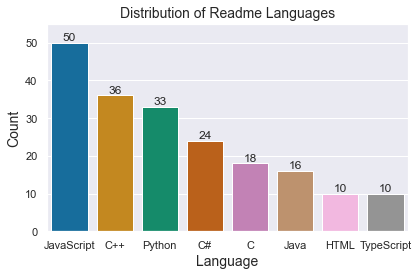

In [18]:
ax = sns.countplot(data=tr,x='language',order=tr.language.value_counts().index); 
#show count
for bar in ax.patches:
    #calculate middle x of bar
    x_pt = bar.get_x() + (bar.get_width() / 2)
    #Add small buffer to height of bar (y)
    y_pt = bar.get_height() + .5
    #plot values - note that the height in this case is the value we want to plot
    ax.text(x = x_pt, y = y_pt, s = bar.get_height(),horizontalalignment='center')

plt.title('Distribution of Readme Languages',size=14)
plt.ylabel('Count',size=14)
plt.xlabel('Language',size=14)
plt.ylim((0,55))
plt.tight_layout()

In [ ]:
#as a function
def plot_target_distro(tr):
    '''
    Plots the distribution of the target variable (language)
    '''
    ax = sns.countplot(data=tr,x='language',order=tr.language.value_counts().index); 
    #show count
    for bar in ax.patches:
        #calculate middle x of bar
        x_pt = bar.get_x() + (bar.get_width() / 2)
        #Add small buffer to height of bar (y)
        y_pt = bar.get_height() + .5
        #plot values - note that the height in this case is the value we want to plot
        ax.text(x = x_pt, y = y_pt, s = bar.get_height(),horizontalalignment='center')

    plt.title('Distribution of Readme Languages',size=14)
    plt.ylabel('Count',size=14)
    plt.xlabel('Language',size=14)
    plt.ylim((0,55))
    plt.tight_layout()
    return None

##### Look at TF and TF-IDF for tes

In [21]:
#aggregate readme contents by language
all_text = ' '.join(tr.content)
javascripttxt = ' '.join(tr[tr.language == 'JavaScript'].content)
pythontxt = ' '.join(tr[tr.language == 'Python'].content)
cplustxt = ' '.join(tr[tr.language == 'C++'].content)
csharptxt = ' '.join(tr[tr.language == 'C#'].content)
ctxt = ' '.join(tr[tr.language == 'C'].content)
javatxt = ' '.join(tr[tr.language == 'Java'].content)
htmltxt = ' '.join(tr[tr.language == 'HTML'].content)
tstxt = ' '.join(tr[tr.language == 'TypeScript'].content)

In [22]:
#create word lists and get value counts for each
all_freq = pd.Series(str(all_text).split()).value_counts()
javascr_freq = pd.Series(str(javascripttxt).split()).value_counts()
python_freq = pd.Series(str(pythontxt).split()).value_counts()
cplus_freq = pd.Series(str(cplustxt).split()).value_counts()
csharp_freq = pd.Series(str(csharptxt).split()).value_counts()
c_freq = pd.Series(str(ctxt).split()).value_counts()
java_freq = pd.Series(str(javatxt).split()).value_counts()
html_freq = pd.Series(str(htmltxt).split()).value_counts()
ts_freq = pd.Series(str(tstxt).split()).value_counts()

In [37]:
#combine into one dataframe
freq_list = [all_freq, javascr_freq, python_freq, cplus_freq, csharp_freq,
             c_freq, java_freq, html_freq, ts_freq]
name_list = ['all','JavaScript','Python','C++','C#','C','Java','HTML','TypeScript']

word_counts = (pd.concat(freq_list,axis=1, sort=True)
                .set_axis(name_list, axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

In [38]:
word_counts.sort_values(by='JavaScript').tail(10)

,all,JavaScript,Python,C++,C#,C,Java,HTML,TypeScript
fix,123,69,4,6,40,2,0,0,2
use,426,74,107,80,93,18,24,2,28
npm,99,79,0,0,0,0,0,0,20
method,206,85,23,52,26,0,13,0,7
run,281,88,61,33,35,14,10,3,37
install,325,90,115,55,23,13,3,2,24
add,250,126,18,19,55,9,13,1,9
class,236,132,9,61,19,0,12,2,1
',892,184,271,119,112,44,25,63,74
game,1763,232,411,174,332,85,116,353,60


In [86]:
#create groupby for content
grouped = pd.DataFrame(tr.groupby(by='language')['content'].transform(lambda x: ' '.join(x)).drop_duplicates())
#get names for the indices
names = [tr.loc[115,'language'], tr.loc[395,'language'],
         tr.loc[166,'language'], tr.loc[348,'language'],
         tr.loc[124,'language'], tr.loc[248,'language'],
         tr.loc[385,'language'], tr.loc[19,'language']]

#set axis labels
grouped.set_axis(names,inplace=True)

In [87]:
grouped

,content
C++,img srchttpsrawgithubusercontentcomgameplay3dg...
HTML,## welcome github game project based learning ...
C#,p aligncenter img srchttpsuserimagesgithubuser...
C,# break arcade game breakout arcade game peop...
JavaScript,## slack poker bot build status bot turn slack...
Java,# gameshardingdb springshardingmybaitsredis sp...
Python,# open source game please visit web page rende...
TypeScript,# heroic game launcher discord github release ...


In [91]:
#Now we can use vectorizer on aggregated columns
tfidf = TfidfVectorizer() #initialize vectorizer
tfidfs = tfidf.fit_transform(grouped.content) #create sparse matrix
tr_tfidf = pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names()) #convert to DataFrame
tr_tfidf.set_index(grouped.index, inplace=True)

In [92]:
tr_tfidf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, C++ to TypeScript
Columns: 13439 entries, 00 to zypper
dtypes: float64(13439)
memory usage: 840.0+ KB


In [93]:
tr_tfidf.head()

,00,0000001,00003,000080highlight,0001,000backgroundcolor,000fontweightnormaltypecsharp,000typecsharp,001,0016666,...,zookeeper,zoorlcardmodels,zork,zot,zracer,ztrack,zulko,zweif,zyliu28mailustceducnmailtozyliu28mailustceducn,zypper
C++,0.007705,0.0,0.0,0.004597,0.000000,0.018388,0.004597,0.004597,0.0,0.004597,...,0.0,0.0,0.000000,0.0000,0.0000,0.0000,0.0,0.0,0.004597,0.003853
HTML,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.006201,0.0037,0.0037,0.0037,0.0,0.0,0.000000,0.000000
C#,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0000,0.0000,0.0000,0.0,0.0,0.000000,0.000000
C,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0000,0.0000,0.0000,0.0,0.0,0.000000,0.000000
JavaScript,0.000000,0.0,0.0,0.000000,0.004123,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.013820,0.0000,0.0000,0.0000,0.0,0.0,0.000000,0.000000


In [103]:
tr_tfidf.sort_values(by='C',axis=1,ascending=False).loc['C',:].head(10)

game         0.404781
header       0.293212
xwindow      0.274269
text         0.170337
version      0.161913
cc           0.155230
skynx        0.155022
available    0.147626
file         0.138102
build        0.133076
Name: C, dtype: float64

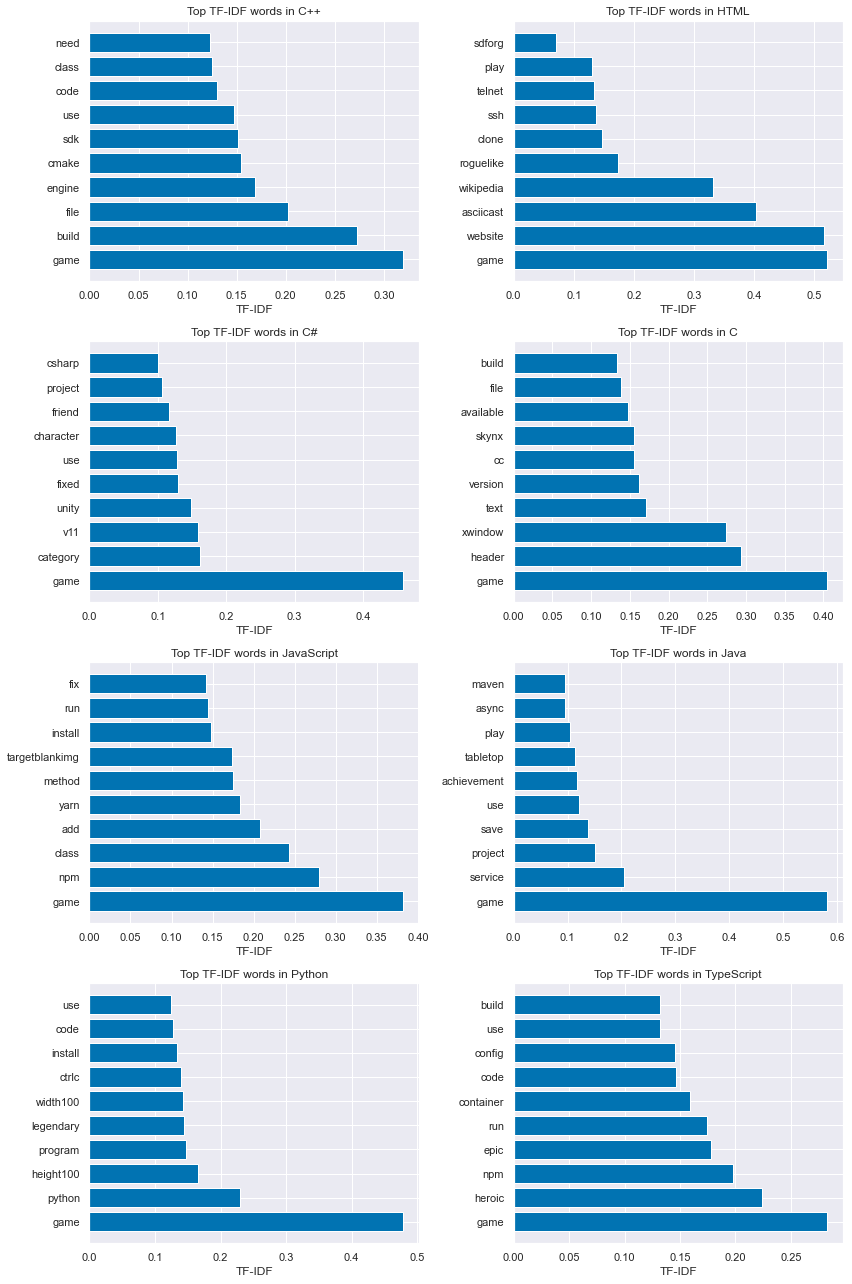

In [116]:
plt.figure(figsize=(12,18))
for cnt,l in enumerate(tr_tfidf.index):
    #sort by language, grab top 10 - series index is name
    top10 = tr_tfidf.sort_values(by=l,axis=1,ascending=False).loc[l,:].head(10)
    
    plt.subplot(4,2,cnt+1)
    #graph first 10 columns
    plt.barh(y=top10.index,width=top10);
    plt.title(f'Top TF-IDF words in {l}');
    plt.xlabel(f'TF-IDF');

plt.tight_layout()